<a href="https://colab.research.google.com/github/bpriantti/projetoML_classifier_retornos_futuros_em_5_dias_PETR4/blob/main/Projeto_ML_classifier_retornos_futuros_em_5_dias_PETR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto ML classifier retornos futuros em 5 dias - PETR4
____

__Bussines Problem:__  


> Durante a rotina de investimentos torna-se atrativo para a tomada de decisão o melhor timing para a exposição e alocação de recursos em um determinado ativo, no entanto os métodos convencionais possuem uma certa subjetividade para essa determinada análise, sendo necessário o desenvolvimento de métodos quantitativos validados de forma científica e objetiva ao longo de 20 anos de série histórica.

__Objetivo:__   

> Desenvolver um modelo de  machine learning para a previsão de retornos em 5 dias futuros para o ativo PETR4, listado na bolsa de valores brasileira B3.

__Autor:__  
   - Bruno Priantti.
    
__Contato:__  
  - bpriantti@gmail.com

__Encontre-me:__  
   -  https://www.linkedin.com/in/bpriantti/  
   -  https://github.com/bpriantti
   -  https://www.instagram.com/brunopriantti/
   

# Python Codes:
___

# install non-native libs:

In [ ]:
!pip install yfinance
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# user functions: 


In [ ]:
#func para verificar estacionariedade das features:
#----------------------------------------------------------------
def stationary(series):
  result = adfuller(series)
  if(result[1] < 0.05):
    return 'stationary'
  else:
    return 'not stationary'

#func para eliminar correl entre features:
#----------------------------------------------------------------
def get_pair_above_threshold(X, threshold):
  correl = X.corr()
  correl = correl.abs().unstack()
  pairs_to_drop = set()
  cols = x.corr().columns
  for i in range(0, x.corr().shape[1]):
    for j in range(0, i+1):
      pairs_to_drop.add((cols[i], cols[j]))
  correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)
  return correl[correl > threshold].index

#func para setar o sinal de trading para o numero de posicoes permitidas
#simultaneamente:
#----------------------------------------------------------------
def signal_filtering(data):
    
    class trade:
      def __init__(self, n_days):
        self.n_days = n_days

      def estado_trade(self):
        if self.n_days <= 0:
          return False
        else:
          self.n_days = self.n_days -1
          return True   

    f1 = False
    n_dias = 5
    data['n_sinal']   = np.zeros(len(data))

    for i in range(len(data)-1):
      sinal = data['sinal'][i]
      if f1 == True:
          f1 = pos_1.estado_trade()

      if f1 != True:
        if sinal == 1:
            pos_1 = trade(n_dias-1)
            data['n_sinal'].iloc[i] = 1
            f1 = True
    
    return data

#func para realizar o backtest dos sinais durante a serie historica de dados:
#----------------------------------------------------------------
def backtest(data,stop):
  data['strategy_returns']   = data['n_sinal']*data['target_returns']
  data['strategy_returns']   = np.where(data['strategy_returns'] <= -stop,-stop,data['strategy_returns'])
  data['cumulative_returns'] = (1+data['strategy_returns']).cumprod()
  data['bh_return'] = (1 + data['Close'].pct_change()).cumprod()
  return data

#func para calcular o drawdown do sistema de trading:
#----------------------------------------------------------------
def dd_calc(data):
  running_max = np.maximum.accumulate(data.dropna())
  running_max[running_max < 1] = 1
  drawdown = ((data)/running_max-1)*100
  return drawdown

#func para avaliar o modelo de ML classifier:
#----------------------------------------------------------------
def model_aval(data):
    from sklearn.metrics import classification_report,confusion_matrix

    # Define the confusion matrix
    confusion_matrix_data = confusion_matrix(data['target_cat'], data['sinal'])

    print('')
    print('Confusion Matrix:  ')
    # Plot the data
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print('')
    print('Classification Report:  ')
    #Classification report
    classification_report_data = classification_report(data['target_cat'], data['sinal'])

    # Print the classification reportf
    print(classification_report_data)

    return data

#import libs:

In [ ]:
#import libs:
import pandas as pd
import numpy as np

#libs para visualization dos dados:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import plotly.express as px
import plotly.graph_objects as Dash

#lib para api com ativos da bolsa:
import yfinance as yf
import talib as ta

#---
import warnings
warnings.filterwarnings("ignore")


# conexao api, request data base:

In [ ]:
# Download base de dados:
ticker = "PETR4.SA"

#datas - atentar para inicio em janeiro do ano de inicio do ativo ou proximo.
start =  "2000-01-01" 
end =    "2022-06-30"

#API - yahoo finance:
data = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,5.875,5.875,5.875,5.875,2.139588,35389440000
2000-01-04,5.550,5.550,5.550,5.550,2.021228,28861440000
2000-01-05,5.494,5.494,5.494,5.494,2.000834,43033600000
2000-01-06,5.475,5.475,5.475,5.475,1.993913,34055680000
2000-01-07,5.500,5.500,5.500,5.500,2.003018,20912640000


In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-23,26.98,27.379999,26.120001,26.490000,21.570530,69262300
2022-06-24,26.76,27.090000,26.180000,26.290001,21.407673,53413400
2022-06-27,26.82,28.070000,26.660000,27.980000,22.783821,90417700
2022-06-28,28.58,28.830000,28.020000,28.330000,23.068823,51388000
2022-06-29,28.48,28.820000,27.840000,28.080000,22.865252,52048800


#visualizando dados de fechamento:

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(x=data.index, y=data['Adj Close']))

fig.update_layout(height=500, width=1000,
                 title_text="Adj Close - PETR4:")
fig.show()

#calculando retornos e var. alvo:

In [ ]:
#set target var:
period = 5

data['target_returns'] = data['Adj Close'].pct_change(period).shift(-period)
data['target_cat'] = np.where(data['target_returns'] > 0.02, 1, 0)

#visualizando o var. alvo:

In [ ]:
import plotly.graph_objects as go
    
fig = go.Figure(data=[go.Histogram(x=data['target_returns'])])

fig.add_shape(type="line",
    x0=0.02, y0=0, x1=0.02, y1=300,
    line=dict(
        color="red",
        width=2,
        dash="dot"))

# add annotation
fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.7,
                                        y=0.8,
                                        showarrow=False,
                                        text="Target Value = 1",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

# add annotation
fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.2,
                                        y=0.8,
                                        showarrow=False,
                                        text="Target Value = 0",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

fig.update_layout(height=500, width=1000,
                 title_text="5d returns distribuition: ")

fig.show()

#calculando features de entrada:

In [ ]:
# percentage change
data['pct_change_1'] = data['Close'].pct_change(1)

# percentage change
data['pct_change_5'] = data['Close'].pct_change(5)

# percentage change
data['pct_change_10'] = data['Close'].pct_change(15)

# Create a column by the name RSI,
data['rsi_14'] = ta.RSI(data['Close'].values,timeperiod=14)

# Create a column by the name ADX
data['adx_14'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=int(14))

# Create a column by the name sma,
data['sma_20'] = data['Close'].rolling(window=20).mean()

#correlacao sma:
data['corrSma_20'] = data['Close'].rolling(window=14).corr(data['sma_20'])

# 1-day and 2-day volatility
data['volatility_10'] = data.rolling(10)['pct_change_1'].std()*100
data['volatility_20'] = data.rolling(20)['pct_change_1'].std()*100

# Drop the missing values
data.dropna(inplace=True)

# Target
y = data[['Close','target_cat','target_returns']].copy()

# Features
x = data[['Open','High','Low','Close','pct_change_1','pct_change_5'
         ,'pct_change_10', 'rsi_14', 'adx_14', 'sma_20','corrSma_20'
         , 'volatility_10', 'volatility_20']].copy()

#analisando estacionariedade das features:

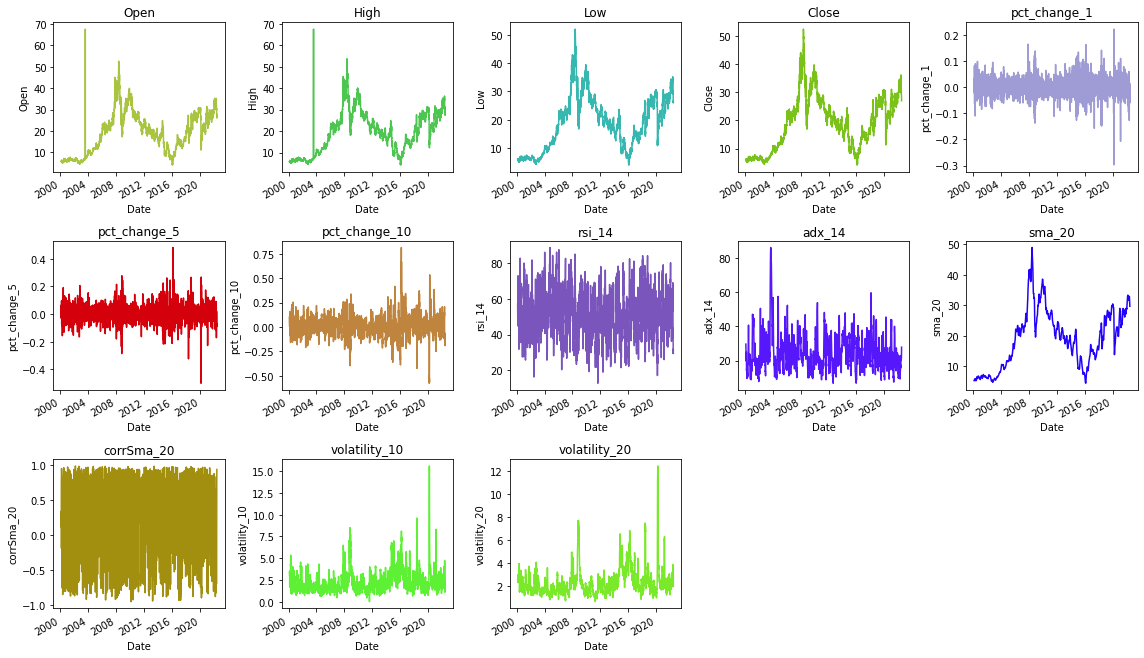

In [ ]:
i=1
nrows = int(x.shape[1]+1/3)
plt.title('Features Stactionarity Check: ')
for feature in x.columns:
    plt.subplot(nrows, 5, i)
    # Plot the feature
    x[feature].plot(figsize=(16,3*x.shape[1]),
    color=np.random.rand(3,))
    plt.ylabel(feature)
    plt.title(feature)
    i+=1

plt.tight_layout()
plt.savefig('image-4')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("check stationarity: ")
for col in x.columns:
  if stationary(data[col]) == 'not stationary':
    print('%s is not stationary. Dropping it.' % col)
    x.drop(columns=[col], axis=1, inplace=True)

print(' ')
print(x.columns)

check stationarity: 
Open is not stationary. Dropping it.
High is not stationary. Dropping it.
Low is not stationary. Dropping it.
Close is not stationary. Dropping it.
sma_20 is not stationary. Dropping it.
 
Index(['pct_change_1', 'pct_change_5', 'pct_change_10', 'rsi_14', 'adx_14',
       'corrSma_20', 'volatility_10', 'volatility_20'],
      dtype='object')


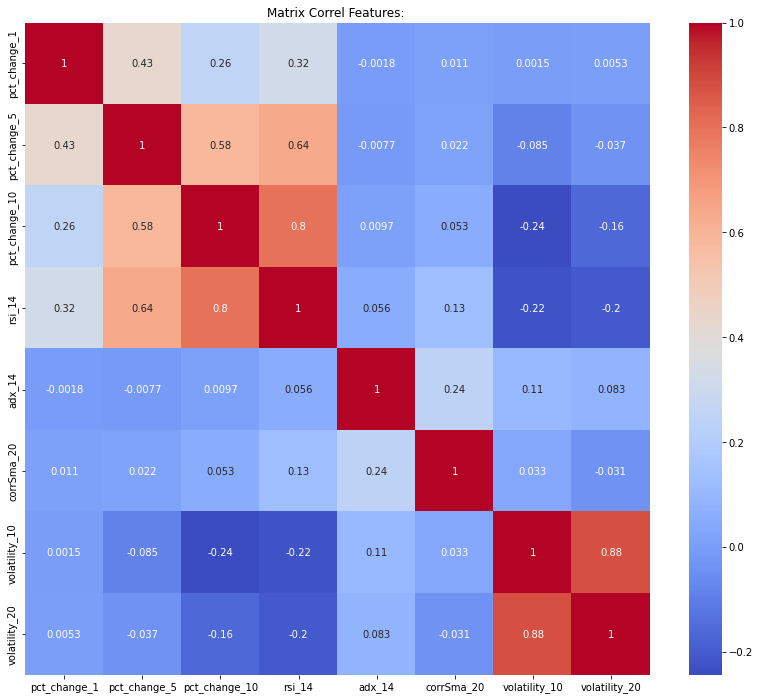

In [ ]:
#verificando features:
plt.figure(figsize=(14,12))
sns.heatmap(x.corr(), annot=True, cmap='coolwarm')

plt.title('Matrix Correl Features: ')

plt.savefig('image')
plt.show()


In [ ]:
#verificando features com alta correl:
print(' ')
print(get_pair_above_threshold(x, 0.7))

# removendo features com alta corr:
x = x.drop(columns=['volatility_20','pct_change_10'], axis=1)

 
MultiIndex([('volatility_10', 'volatility_20'),
            ('pct_change_10',        'rsi_14')],
           )


#exportando base de dados:

In [ ]:
x.to_csv('x_data.csv')
y.to_csv('y_data.csv')

# train-test-val (Data Split):

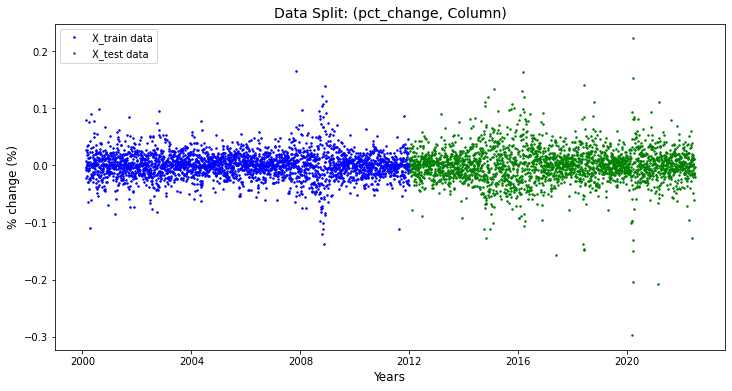

In [ ]:
#---------------------------------
s_train = "2000-01-01"
e_train = "2011-12-31"
#---------------------------------
s_test = "2012-01-01"
e_test = "2022-12-31"
#---------------------------------
x_train = x[s_train : e_train]
x_test  = x[s_test : e_test]
#---------------------------------
y_train = y[s_train : e_train]
y_test  = y[s_test : e_test]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x_train['pct_change_1'], linestyle='None', marker='.', markersize=3.0, label='X_train data', color='blue')
plt.plot(x_test['pct_change_1'], linestyle='None', marker='.', markersize=3.0, label='X_test data', color='green')

# Set the title and axis label
plt.title("Data Split: (pct_change, Column)",fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.savefig('image')
plt.show()

# ml model research:

decisiontreeclassifier:


Confusion Matrix:  


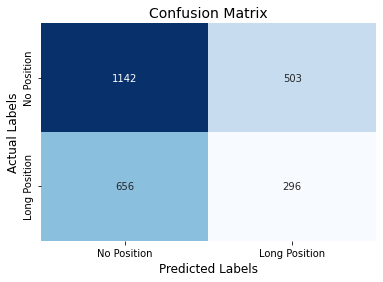


Classification Report:  
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1645
           1       0.37      0.31      0.34       952

    accuracy                           0.55      2597
   macro avg       0.50      0.50      0.50      2597
weighted avg       0.54      0.55      0.54      2597



In [ ]:
from sklearn.tree import DecisionTreeClassifier

#---(criterion='gini', max_depth=20,min_samples_leaf=1,random_state=1)
model_1 = DecisionTreeClassifier(criterion='gini', max_depth=10,min_samples_leaf=10,random_state=1)
model_1 = model_1.fit(x_train, y_train['target_cat'])

#check base de treino/teste:
y_test['sinal'] = model_1.predict(x_test)

#---
d_tree  = model_aval(y_test).copy()

gradientboostingclassifier:


Confusion Matrix:  


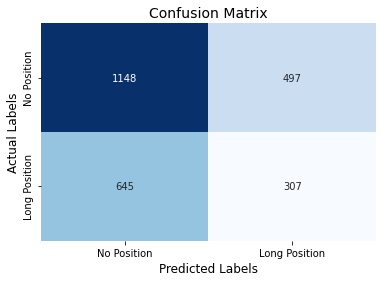


Classification Report:  
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1645
           1       0.38      0.32      0.35       952

    accuracy                           0.56      2597
   macro avg       0.51      0.51      0.51      2597
weighted avg       0.55      0.56      0.55      2597



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_2 = GradientBoostingClassifier(max_depth = 25, n_estimators=100,learning_rate=0.6,max_leaf_nodes=55,min_samples_leaf = 1,random_state=1)

model_2.fit(x_train, y_train['target_cat'])

#check base de teste:
y_test['sinal'] = model_2.predict(x_test)

#---
gb_booster = model_aval(y_test).copy()

kneighborsclassifier:


Confusion Matrix:  


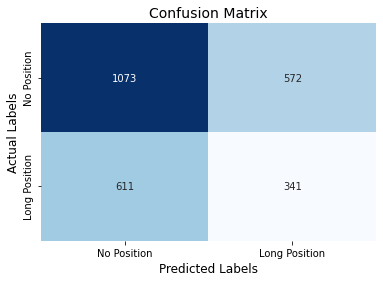


Classification Report:  
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1645
           1       0.37      0.36      0.37       952

    accuracy                           0.54      2597
   macro avg       0.51      0.51      0.51      2597
weighted avg       0.54      0.54      0.54      2597



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_3 = KNeighborsClassifier(n_neighbors=3, leaf_size= 10,weights='distance')

# Fit the model
model_3.fit(x_train, y_train['target_cat'])

#check base de teste:
y_test['sinal'] = model_3.predict(x_test)

#---
knn = model_aval(y_test).copy()

supportvectormachine


Confusion Matrix:  


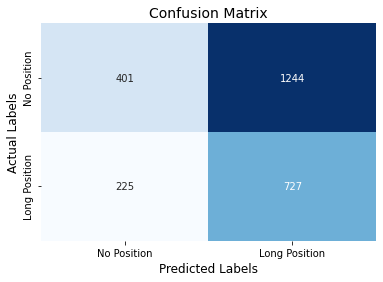


Classification Report:  
              precision    recall  f1-score   support

           0       0.64      0.24      0.35      1645
           1       0.37      0.76      0.50       952

    accuracy                           0.43      2597
   macro avg       0.50      0.50      0.43      2597
weighted avg       0.54      0.43      0.41      2597



In [ ]:
from sklearn.svm import SVC 

model_4 = SVC(kernel = "rbf", max_iter = 500, gamma = "scale",random_state = 1)

# Fit the model
model_4.fit(x_train, y_train['target_cat'])

#check base de teste:
y_test['sinal'] = model_4.predict(x_test)

#---
svm = model_aval(y_test).copy()

enssemble stacking:


Confusion Matrix:  


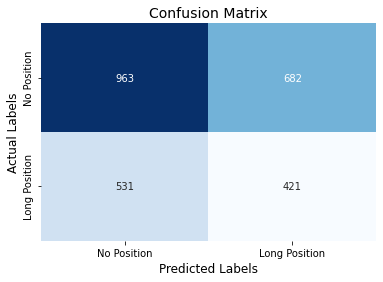


Classification Report:  
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      1645
           1       0.38      0.44      0.41       952

    accuracy                           0.53      2597
   macro avg       0.51      0.51      0.51      2597
weighted avg       0.55      0.53      0.54      2597



In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [('model_2',model_2),
              ('model_3',model_3),
              ('model_4',model_4)]


ensb =  VotingClassifier(estimators= estimators, voting='hard') 

ensb.fit(x_train, y_train['target_cat'])

#check base de teste:
y_test['sinal'] = ensb.predict(x_test)

#---
ensb_ = model_aval(y_test).copy()

# BackTest:

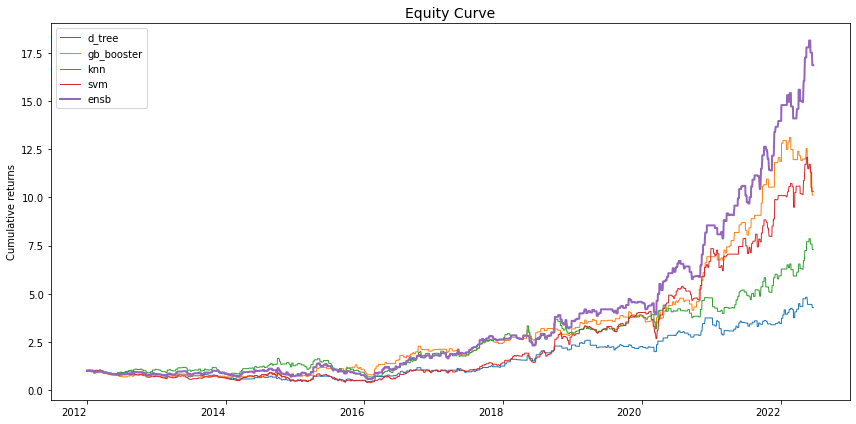

In [ ]:
#-------------------------------------------------------------------------------

stop = 0.10

d_tree = signal_filtering(d_tree)
gb_booster = signal_filtering(gb_booster)
knn = signal_filtering(knn)
svm = signal_filtering(svm)
ensb_ = signal_filtering(ensb_)

d_tree = backtest(d_tree,stop)
gb_booster = backtest(gb_booster,stop)
knn = backtest(knn,stop)
svm = backtest(svm,stop)
ensb_ = backtest(ensb_, stop)

# ---------------------Equity Curve--------------------------------------------

# Plot cumulative strategy returns:
plt.figure(figsize = (12,6))
plt.plot(d_tree['cumulative_returns']     , label = 'd_tree',linewidth = 1)
plt.plot(gb_booster['cumulative_returns'] , label = 'gb_booster',linewidth = 1)
plt.plot(knn['cumulative_returns']        , label = 'knn',linewidth = 1)
plt.plot(svm['cumulative_returns']        , label = 'svm',linewidth = 1)
plt.plot(ensb_['cumulative_returns']      , label = 'ensb',linewidth = 2)

#-------------------------------------------------------------------------------
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=0, ha='right')

plt.savefig('image')

plt.show()



#Salvando Modelo:

In [ ]:
import pickle

#save:
filename = "model_PETR4.sav"
pickle.dump(ensb, open(filename, "wb"))

#save:
filename = "model_PETR4.sav"
model = pickle.load(open(filename, "rb"))

# Model Vs Benchmark:

In [ ]:
previsao = model.predict(x_test)

y_test_cpy = y_test.copy()

y_test_cpy['sinal'] = previsao

y_test_cpy = signal_filtering(y_test_cpy)

stop = 0.15
y_test_cpy = backtest(y_test_cpy,stop)

y1   = y_test_cpy['cumulative_returns'].copy()
y1_1 = y_test_cpy['bh_return'].copy()

y2   = dd_calc(y_test_cpy['cumulative_returns'])
y2_2 = dd_calc(y_test_cpy['bh_return'])

#data visualization:

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1,row_heights=[0.75, 0.25]
                   ,shared_xaxes=True
                   ,vertical_spacing=0.02)

fig.add_trace(go.Scatter(x=y_test.index, y =y1,name = 'ML model'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=y_test.index, y = y1_1,name = 'Ibovespa'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=y_test.index, y=y2,name = 'DD Ml model'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=y_test.index, y=y2_2,name = 'DD Ibovespa'),
              row=2, col=1)

fig.update_layout(height=600, width=1000,
                  title_text="Model vs Benchmark:(Equity/Drawdown) ")
fig.show()

verificando performance anual:

In [ ]:
#anual returns:

df_data = y_test_cpy.reset_index()

#extraindo o dia da semana:
df_data['week day'] = df_data['Date'].apply(lambda x:x.strftime('%A'))

#extraindo o mes:
df_data['month'] = df_data['Date'].apply(lambda x:x.strftime('%m'))

#extraindo o ano:
df_data['year'] = df_data['Date'].apply(lambda x:x.strftime('%Y'))

#calculando os retornos mensais
df_data_0 = df_data[['strategy_returns','month','year']].groupby(['year','month']).agg('sum')


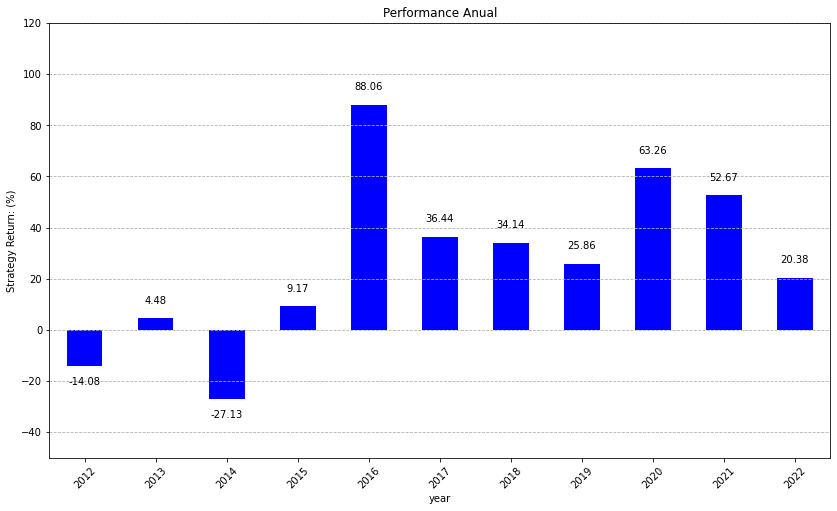

In [ ]:
ret_anual = df_data_0.groupby('year').agg(sum)*100

frequencies = ret_anual['strategy_returns']
freq_series = pd.Series(frequencies)

x_labels = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']

# Plot the figure.
plt.figure(figsize=(14, 8))
ax = freq_series.plot(kind="bar", color = 'blue')
ax.set_title("Performance Anual")
ax.set_ylabel("Strategy Return: (%)")
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-50,120)
rects = ax.patches

#labels:
labels = round(ret_anual['strategy_returns'],2)

for rect, label in zip(rects, labels):
    if label >0:
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
    else:
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height -8, label, ha="center", va="bottom")


plt.grid(axis = 'y',linestyle='--')     
plt.savefig('image.png')
plt.show()
